<a href="https://colab.research.google.com/github/joanmaller/btbs/blob/main/Homework2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Biometrich Technologies and Behavioural Security
# **<center>Homework 2 - Fingerprint Liveness Detection</center>**






This homework was based on the BSIF and LBP feature extractors and the experimentation of different classifiers.

## Step 1: Load data and packages in your VM

You are surely familiar with the following procedure. In particular, we are loading:

1.   A small dataset of live and fake fingerprint samples.
2.   Linear filters for BSIF descriptor, with different size and number of features extracted.

If you don't see the files at the end of the process, press the *Refresh* button.

In [ ]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
from scipy import signal
import scipy.io
import math
import sys
import time
from IPython.display import HTML, display
from IPython.display import clear_output
 
#Function for progress bar.
def progress(value, max=100):
    return HTML("""<progress value='{value}' max='{max}', style='width: 100%'>
            {value}
        </progress>""".format(value=value, max=max))
 
#Loading part
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
 
 
downloaded = drive.CreateFile({'id': '14uxaaguRQ1ii2HYPzRvp5MQB1hlNRHrT'})   # replace the id with id of file you want to access
downloaded.GetContentFile('dataset_esercitazione.zip')        # replace the file name with your file
!unzip dataset_esercitazione
clear_output()
print('Done! Run the BSIF Filters download code.')

Done! Run the BSIF Filters download code.


In [ ]:
#BSIF Filters download code
downloaded = drive.CreateFile({'id': '1CPk07Oqn5gmKn8yXaEns-0yZc5ZAs3Su'})   # replace the id with id of file you want to access
downloaded.GetContentFile('texturefilters.zip')        # replace the file name with your file
!unzip texturefilters
clear_output()
print('Done! Press the Refresh button if files are not visible.')

Done! Press the Refresh button if files are not visible.


###**Dataset Structure**

The fingerprint images are located in the "dataset_esercitazione" directory. There are a total of 400 fingerprint images in **Train** sub-directory, as follows:
 *   200 fingerprint <font color=green>**Live**</font> samples
 *   200 fingerprint <font color=red>**Fake**</font> samples

From the 200 <font color=red>**Fake**</font> samples:
 *   50 Eco-flex samples
 *   50 Gelatine samples
 *   50 Latex samples
 *   50 Woodglue samples

As in the tutorial 2, We choose both different identities and fingers randomly, but to have always 10 samples per finger.
The images are labelled with the user ID (which has random value), finger ID (which ranges from 0 to 9) and sample ID (which ranges from 0 to 9). So, for example:

 - Fingerprint **<font color='green'>011</font>_<font color='red'>6</font>_0** = the **1st** fingerprint sample captured from finger **<font color='red'>6</font>** (e.g. Left Thumb) of user **<font color='green'>"011"</font>**
 - Fingerprint **<font color='green'>014</font>_<font color='red'>1</font>_3** = the **4th** fingerprint sample captured from finger **<font color='red'>1</font>** (e.g. Right Index) of user **<font color='green'>"014"</font>**
 - and so on...

## Step 2: BSIF method definition

The code below is the Python porting of the BSIF Matlab code, as mentioned above. The method computes a **binary code** string for the pixels of a given image. The code value of a pixel is considered as a local descriptor of the image intensity pattern in the pixel’s surroundings. The value of each element (i.e. bit) in our **binary code** string is computed by binarizing the response of a linear ﬁlter with a threshold at zero. Each bit is associated with a different ﬁlter and the **desired length of the bit string** determines the **number of ﬁlters** used. The set of ﬁlters is learnt from a training set of natural image patches by maximizing the statistical independence of the ﬁlter responses.

Run the cell to define a function named **bsif**, that takes as argument:

*   An *image* to be processed.
*   The path of the chosen *filter*.


In [ ]:
def bsif(img, filterpath):
    f = scipy.io.loadmat(filterpath)
    texturefilters = f.get('ICAtextureFilters')

    # Initialize
    img = img.astype('float');
    numScl = np.shape(texturefilters)[2]
    codeImg = np.ones(np.shape(img))

    # Make spatial coordinates for sliding window
    r = int(math.floor(np.shape(texturefilters)[0] / 2))

    # Wrap image (increase image size according to maximum filter radius by wrapping around)
    upimg = img[0:r, :]
    btimg = img[-r:, :]
    lfimg = img[:, 0:r]
    rtimg = img[:, -r:]
    cr11 = img[0:r, 0:r]
    cr12 = img[0:r, -r:]
    cr21 = img[-r:, 0:r]
    cr22 = img[-r:, -r:]
    imgWrap = np.vstack(
        (np.hstack((cr22, btimg, cr21)), np.hstack((rtimg, img, lfimg)), np.hstack((cr12, upimg, cr11))))

    # Loop over scales
    for i in range(numScl):
        tmp = texturefilters[:, :, numScl - i - 1]
        ci = signal.convolve2d(imgWrap, np.rot90(tmp, 2), mode='valid')
        t = np.multiply(np.double(ci > 0), 2 ** i)
        codeImg = codeImg + t

    hist_bsif = np.histogram(codeImg.ravel(), bins=np.arange(1,(2**numScl)+2))
    hist_bsif = hist_bsif[0]
    # normalize the histogram
    hist_bsif = hist_bsif/(hist_bsif.sum() + 1e-7)
  

    return codeImg, hist_bsif

Summing up, there are two main parameters in the BSIF descriptor:

1.   Filter window size **l** 
2.   Length **n** of the bit string

We choose the window size equal to 7x7, and features number 4096 (corresponding to 12 bits)

In [ ]:
file_path = "/content/texturefilters/ICAtextureFilters_9x9_8bit.mat"

### Step 2.1 Take a look at the output

With the following code, you can display the resulting BSIF code computed for a generic fingerprint image. 

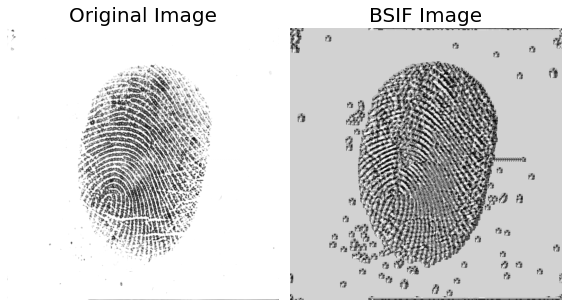

In [ ]:
#Example of BSIF Image

image_file = '/content/Train/Live/019_8_0.png'
img_gray = cv2.imread(image_file,0)
img_bsif,hist = bsif(img_gray,file_path)

#show images
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 8), sharex=True, sharey=True)
plt.subplots_adjust(0.15)
axes[0].imshow(img_gray, cmap="gray")
axes[0].axis('off')
axes[0].set_title('Original Image', fontsize=20)
axes[1].imshow(img_bsif,cmap="gray")
axes[1].axis('off')
axes[1].set_title('BSIF Image', fontsize=20)
fig.tight_layout()
plt.show()


## Step 3: Feature Extraction

At this point, we have to extract all BSIF codes from our fingerprint dataset. For "time-saving" purposes, we'll compute them only for *Train* sub-folder. In each row of **data** variable, we store a different *bit code* composed by 4096 elements (remember that we are using 12 bit filters), while in **labels** variable, we store:

*   **1** if the fingerprint image comes from <font color=green>**Live**</font> sub-directory
*   **0** if the fingerprint image comes from <font color=red>**Fake**</font> sub-directory



In [ ]:
#Initialize data and labels array
data = []
labels = []

In [ ]:
def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)            
    return allFiles

In [ ]:
path = "/content/Train/"
train_images = getListOfFiles(path)

print('Extracting BSIF Code (5 minutes)...')
out = display(progress(0, len(train_images)*2), display_id=True)
kk=0
t = time.time()

for i in train_images:
    gray = cv2.imread(i,0)
    img_bsif,hist = bsif(gray,file_path)
    
    data.append(hist)
    if "Live" in i:
        labels.append(1)
    elif "Fake" in i:
        labels.append(0)
    kk=kk+1
    out.update(progress(kk, len(train_images)*2))

elapsed = 'Process completed! Elapsed time: %.2f s' %(time.time() - t)
print(elapsed)

Extracting BSIF Code (5 minutes)...


Process completed! Elapsed time: 214.49 s


## Step 4: Classification with kNN

Once features extracted, we have to test the accuracy of our **BSIF-based Liveness Detector**, in other words we are answering the following question:

<font size=4>***If we design a FPAD based on this textural descriptor, how many attacks can we avoid?***</font>

*Let's find out.*

In [ ]:
#Split data array in train and test data for kNN

from sklearn.model_selection import train_test_split
data = np.array(data)
labels = np.array(labels)
X_train,X_test,y_train,y_test = train_test_split(data,labels,test_size = 0.2) 

In [ ]:
#Train kNN classifier
from sklearn.neighbors import KNeighborsClassifier as kNN
clf = kNN(n_neighbors=2)
clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=2)

In [ ]:
#Predict test labels and accuracy

y_pred = clf.predict(X_test)
from sklearn.metrics import accuracy_score
acc='Total Accuracy: %.2f %%' % (accuracy_score(y_test, y_pred)*100)
print(acc)

Total Accuracy: 72.50 %


This model gives us accuracies of max 83.75, but some of them 77.50 or 72.50, we will try to improve it




## Step 3b: Feature Extraction distinguishing classes of fakes

At this point, we have to extract all BSIF codes from our fingerprint dataset. For "time-saving" purposes, we'll compute them only for *Train* sub-folder. In each row of **data** variable, we store a different *bit code* composed by 4096 elements (remember that we are using 12 bit filters), while in **labels** variable, we store:

*   **0** if the fingerprint image comes from <font color=green>**Live**</font> sub-directory
*   **1** if the fingerprint image comes from **Ecoflex** sub-directory
*   **2** if the fingerprint image comes from **Gelatine** sub-directory
*   **3** if the fingerprint image comes from **Latex** sub-directory
*   **4** if the fingerprint image comes from **WoodGlue** sub-directory



In [ ]:
#Initialize data and labels array
data = []
labels = []

In [ ]:
def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)            
    return allFiles

In [ ]:
path = "/content/Train/"
train_images = getListOfFiles(path)

print('Extracting BSIF Code (5 minutes)...')
out = display(progress(0, len(train_images)*2), display_id=True)
kk=0
t = time.time()

for i in train_images:
    gray = cv2.imread(i,0)
    img_bsif,hist = bsif(gray,file_path)
    
    data.append(hist)
    if "Live" in i:
        labels.append(0)
    elif "Ecoflex" in i:
        labels.append(1)
    elif "Gelatine" in i:
        labels.append(2)
    elif "Latex" in i:
        labels.append(3)
    elif "WoodGlue" in i:
        labels.append(4)
        
    kk=kk+1
    out.update(progress(kk, len(train_images)*2))

elapsed = 'Process completed! Elapsed time: %.2f s' %(time.time() - t)
print(elapsed)

Extracting BSIF Code (5 minutes)...


Process completed! Elapsed time: 213.25 s


## Step 4b: Classification with kNN distinguishing classes of fakes

In [ ]:
#Split data array in train and test data for SVM

from sklearn.model_selection import train_test_split
data = np.array(data)
labels = np.array(labels)
X_train,X_test,y_train,y_test = train_test_split(data,labels,test_size = 0.2) 

In [ ]:
#Train kNN classifier
from sklearn.neighbors import KNeighborsClassifier as kNN
clf = kNN(n_neighbors=4) 
clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4)

In [ ]:
#Predict test labels and accuracy

y_pred = clf.predict(X_test)
from sklearn.metrics import accuracy_score
acc='Total Accuracy: %.2f %%' % (accuracy_score(y_test, y_pred)*100)
print(acc)

Total Accuracy: 67.50 %


This model gives us an accuracy of 72.50% or lower, making it worse the previous one




In [ ]:
print(np.shape(data))
print(np.shape(labels))

(400, 256)
(400,)


## Step 3c: Feature extraction with LBP

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import time
from skimage import feature
from IPython.display import HTML, display
from IPython.display import clear_output

np.set_printoptions(suppress=True)
class LocalBinaryPatterns:
	def __init__(self, numPoints, radius):
		# store the number of points and radius
		self.numPoints = numPoints
		self.radius = radius

	def describe(self, image, eps=1e-7):
		# compute the Local Binary Pattern representation
		# of the image, and then use the LBP representation
		# to build the histogram of patterns
		lbp = feature.local_binary_pattern(image, self.numPoints,
			self.radius, method="uniform")
		(hist, _) = np.histogram(lbp.ravel(),
			bins=np.arange(0, self.numPoints + 3),
			range=(0, self.numPoints + 2))

		# normalize the histogram
		hist = hist.astype("float")
		#eps is a small float added to avoid dividing by zero
		hist /= (hist.sum() + eps)

		# return the histogram of Local Binary Patterns
		return hist

In [ ]:
'''
    For the given path, get the List of all files in the directory tree 
'''
def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles

In [ ]:
#set the number of points and the radius dimension
desc = LocalBinaryPatterns(24, 10)
#Initialize 2 lists to create our training set
data = []
labels = []
path = "/content/Train/"
train_images = os.listdir(path)

print('Extracting LBP Code for Train folder...')
out = display(progress(0, len(train_images)*2), display_id=True)
kk=0
t = time.time()

for i in train_images:
    path = path + i
    train_images = os.listdir(path)
    for j in train_images:
        if "Live" in i:
          gray = cv2.imread(path+"/"+j,0)
          print(path, j)
          hist = desc.describe(gray)
          data.append(hist)
          kk=kk+1
          out.update(progress(kk, len(train_images)*2))
          labels.append(1) # Live
              
        elif "Fake" in i:
          auxpath = path
          path = path + "/" + j
          train_images = os.listdir(path)
          for k in train_images:
            print(path, k)
            gray = cv2.imread(path+"/"+k,0)
            hist = desc.describe(gray)
            data.append(hist)
            labels.append(0)
            kk=kk+1
            out.update(progress(kk, len(train_images)*2))
          path = auxpath
           # Fake


    path = "/content/Train/"

elapsed = 'Process completed! Elapsed time: %.2f s' %(time.time() - t)
print(elapsed)
print(np.shape(data))
print(np.shape(labels))

## Step 4c: Classification with NN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
#the validation set will consist of 20% of the data, where we will plot ROC curve
X_train,X_test,y_train,y_test = train_test_split(np.array(data),np.array(labels),test_size = 0.2)
print(np.shape(data), np.shape(labels))
print(np.shape(X_train), np.shape(X_test), np.shape(y_train), np.shape(y_test))

model = Sequential()
model.add(Dense(16, input_dim=26, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(6, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

(400, 26) (400,)
(320, 26) (80, 26) (320,) (80,)


In [ ]:


X_train,X_val,y_train,y_val = train_test_split(np.array(X_train),np.array(y_train),test_size = 0.2)
history = model.fit(X_train,y_train,
              batch_size=10,
              epochs=500,
              validation_data=(X_val, y_val),
              shuffle=True)

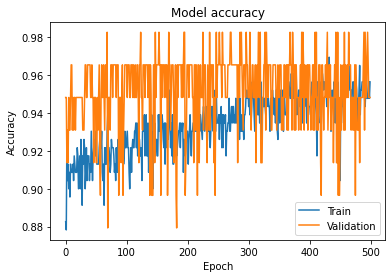

In [ ]:
#Our model is working fine. Now we will visualize training and validation losses and accuracies.
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

## Step 5: Testing the model

In [ ]:

scr = model.predict(X_test) # We extract the score for each class ...
y_pred = np.rint(scr)     # ... and then we round it to the nearest integer
from sklearn.metrics import accuracy_score
acc='Total Accuracy: %.2f %%' % (accuracy_score(y_test, y_pred)*100)
print(acc)
score = model.evaluate(X_test, y_test, batch_size=250)
print(score)



Total Accuracy: 95.00 %
1/1 [==============================] - 0s 47ms/step - loss: 0.1578 - accuracy: 0.9500
[0.1577642261981964, 0.949999988079071]


With an accuracy of 95%, it performs better than the previous models.

In [ ]:

#Separate scores of genuines and impostors

genuines = scr[y_pred==1]
impostors = scr[y_pred==0]

#scores normalization in range [0,1]
mx = max(np.concatenate((genuines,impostors),axis=0))
mn = min(np.concatenate((genuines,impostors),axis=0))
genuines = (genuines - mn)/(mx-mn)
impostors = (impostors - mn)/(mx-mn)

#Inizialize arrays for FRR and FAR storage
FRR=np.zeros((100,1))
FAR=np.zeros((100,1))

#We set a 100 points threshold, from 0 (all users accepted) to 1 (nobody refused).
#P.S. We can do this because now the match scores are normalized.
th=np.linspace(0,1,100); 

for i,t in enumerate(th):
  
  # "t" is the threshold value for each iteration

  count=len(np.argwhere(impostors>=t))   #change hashtags with the right comparison for FAR
  FAR[i,0]=count/len(impostors)*100                              #complete the formula (remember that FAR is a % value)

  count=len(np.argwhere(genuines<t))  #change hashtags with the right comparison for FRR
  FRR[i,0]=count/len(genuines)*100                              #complete the formula (remember that FRR is a % value)


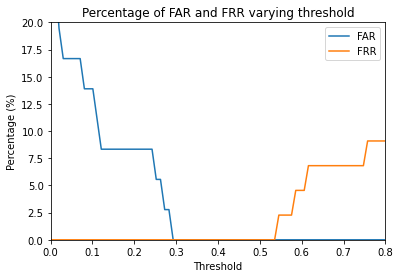

In [ ]:
#Plot FAR, FRR vs threshold

fig, ax = plt.subplots()
line = ax.plot(th, FAR, label='FAR')
line2 = ax.plot(th, FRR, label= 'FRR')
ax.set(xlabel='Threshold', ylabel='Percentage (%)',
       title='Percentage of FAR and FRR varying threshold')
ax.legend()
ax.set_ylim([0,20]) #Uncomment this to zoom cross point
ax.set_xlim([0.0,0.8])#Uncomment this to zoom cross point
plt.show()

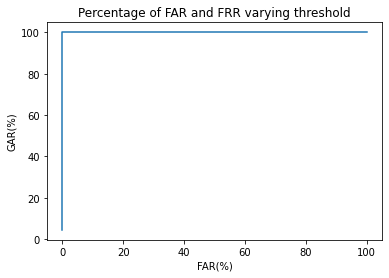

In [ ]:
#Plot FAR vs GAR aka ROC curve

fig, ax = plt.subplots()
ax.plot(FAR, 100-FRR)
ax.set(xlabel='FAR(%)', ylabel='GAR(%)',
       title='Percentage of FAR and FRR varying threshold')
plt.show()